# Präsenzversuch zum Laval-Rotor

Name: Valentin Kämmerer 

Datum: 04.02.2024

Gruppe: 45

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Lassen sich mit Hilfe des Laborversuchaufbaus, durch Messung der Schwingung und Drehzahl und durch gezieltes ansteuern gewisser Drehzahlniveaus, die Eigenfrequenzen (also die kritischen Drehzahlen) ermitteln? Wie werden diese sichtbar im Diagramm? Sind sie ähnlich zu der vorher berechneten kritischen Drehzahl?

## Erster Versuch: Prüfstand 3
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/Lavalrotor-Laborversuch.jpg" width="700">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Der Versuchsaufbau besteht aus einem bürstenlosen Gleichstrommotor, welcher eine Welle aus Stahl antreibt, auf welcher eine einzige Stahlscheibe mittig angebracht ist (siehe Bild). Die Welle ist durch zwei Pendelkugellager Fest-Los-gelagert und diese können keine Momente aufnehmen. Die Welle hat eine Länge von 0,75m und einen Durchmesser von 10mm. Die Scheibe hat eine Masse von 900g, einen Durchmesser von 99mm und eine Dicke von 15mm. 
Der Versuch funktioniert so, dass das Programm den Rotor auf eine vorher definierte maximale Drehzahl fährt und diesen zwischenzeitlich immer bei gewählten Drehzahlniveaus einige Sekunden lang hält, damit dort mehrere Messpunkte ermittelt werden können. Die Schwingungen werden durch einen Beschleunigungssensor ermittelt (im Bild bei der rechten Lagerung gut zu erkennen), welcher an einem Lagerbock befestigt ist. Die Drehzahl wird von einem Hallsensor ermittelt. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_092536_lavalrotor_45_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240119_092536_lavalrotor_45_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
#Daten aus der hdf5 auslesen und im dict measurement_data abspeichern
#hdf5 Pfad definieren
hdf5_path = path_measurement_folder+"/"+filename
f = h5py.File(hdf5_path,"r")

#leeres dict erstellen
measurement_data = {}
#keys erstellen um die jeweiligen Ordner der hdf5 Datei (insgesamt 20 Ordner für jeweils spezielle Drehzahlen) auszulesen zu können
keys = list(range(20))

#Schleife erstellen um Ordner nach und nach auszulesen
for ii in keys:
    #Ordner definieren (jeweils für spezielle Drehzahlen)
    foulder = str(ii)
    #Beschleunigungssensor
    acceleration_sensor = f[foulder]["RawData"][uuid_acceleration]
    #Hallsensor (also zumindest die uuid welche die Motordrehzahl misst)
    hall_sensor = f[foulder]["RawData"][uuid_motor_rpm]
    
    #Beschleunigungen und timesamps des Beschleunigungssensors auslesen
    #Die Messdaten der drei Beschleunigungsrichtungen des Sensors auslesen für die jeweiligen Drehzahlen (Ordner)
    acceleration_x = np.array(acceleration_sensor['acceleration_x'])
    acceleration_y = np.array(acceleration_sensor['acceleration_y'])
    acceleration_z = np.array(acceleration_sensor['acceleration_z'])
    #Zeit auslesen
    timestamp = np.array(acceleration_sensor['timestamp'])
    
    #Motordrehzahl auslesen gemessen vom Hallsensor
    motor_rpm = np.array(hall_sensor['motor_rpm'])
    
    #die ausgelesenen Daten in dem dict abspeichern, damit sie beim erneuten durchlaufen der for Schleife nicht überchrieben werden
    measurement_data.update({str(ii):{"acceleration_x" : acceleration_x, "acceleration_y" : acceleration_y, "acceleration_z" : acceleration_z, "timestamp" : timestamp, "motor_rpm" : motor_rpm}})


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions
#aus dem erstellten Dict die Beschleunigungen auslesen als Input für die Funktion get_vec_accel()
#-->wieder mit einer for Schleife (es existieren Beschleunigungswerte für die jeweiligen Drehzahlbereiche)
for ii in keys:
    acc_x = measurement_data[str(ii)]["acceleration_x"]
    acc_y = measurement_data[str(ii)]["acceleration_y"]
    acc_z = measurement_data[str(ii)]["acceleration_z"]
    amount_acc_vec = m_postprocessing.get_vec_accel(acc_x, acc_y, acc_z)
    #Den Betrag des Beschleunigungsvektors dem Data dict hinzufügen
    measurement_data[str(ii)]["amount_acc_vec"] = amount_acc_vec
    
    #timestamps auslesen für die interpolation Funktion
    timestamp = measurement_data[str(ii)]["timestamp"]
    #mit den Inputs (gegebenen Interpolationspunkten und der Zeit) die jeweiligen Beträge für die jeweiligen Drehzahlen interpolieren
    interpolation_data = m_postprocessing.interpolation(timestamp, amount_acc_vec, interpolation_points)
    #Die Interpolierten Daten dem dict hinzufügen
    measurement_data[str(ii)]["interpolation_data"] = interpolation_data
    
    #Transformation der Daten in den Frequenzbereich mit der my_fft_scaled() Funktion
    transformation_data = m_postprocessing.my_fft_scaled(interpolation_data, timestamp)
    #dem dict hinzufügen
    measurement_data[str(ii)]["transformation_data"] = transformation_data   

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

Text(0.5, 0, 'Drehzahl in 1/s')

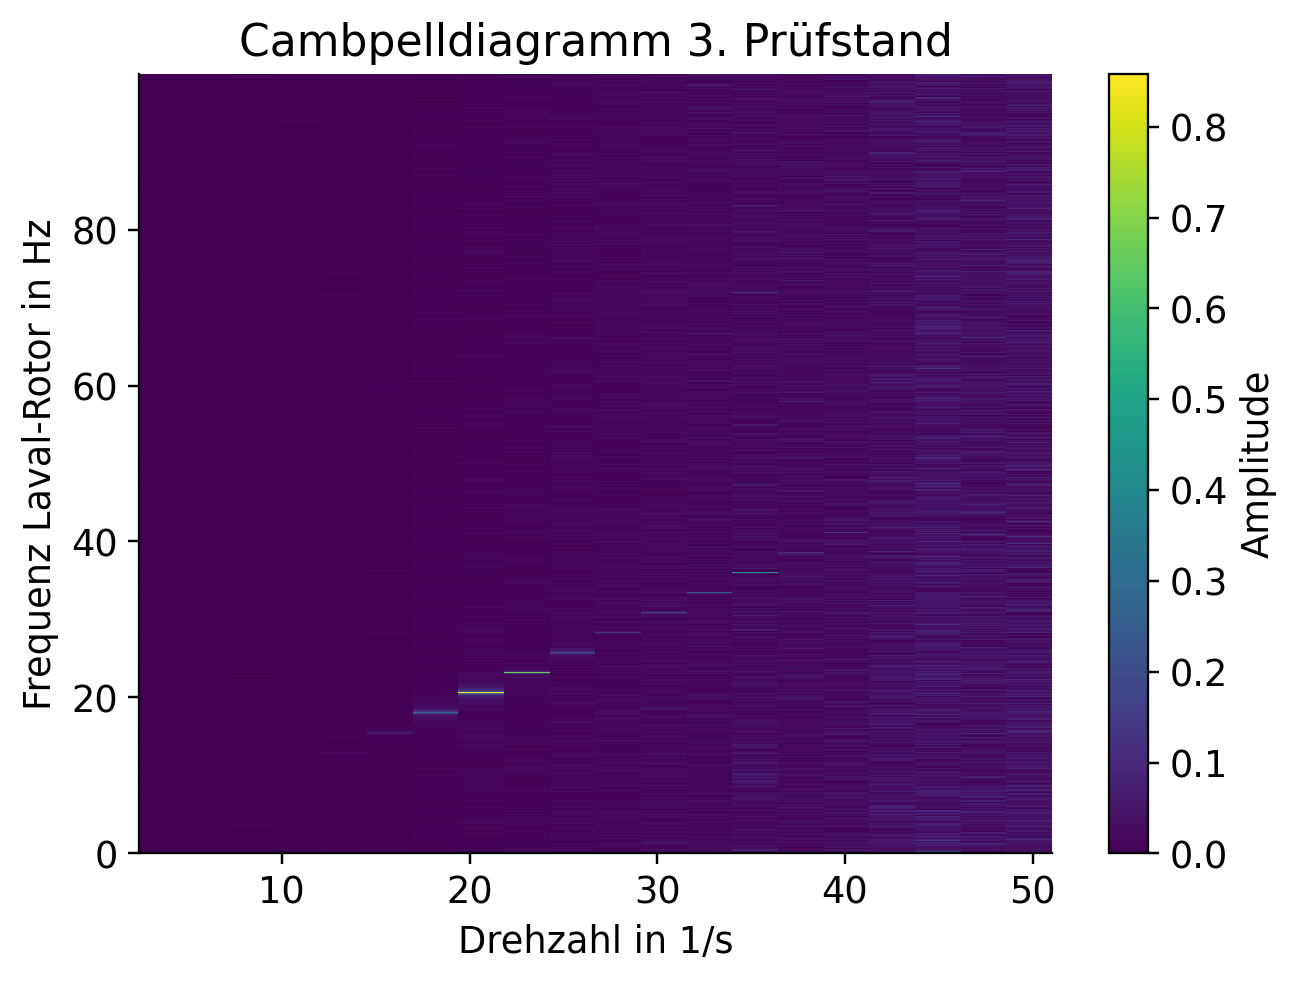

In [7]:
#aus den Messdaten die erste gemessene Drehzahl auslesen und darin den ersten array der transformation_data auslesen, was der Frequenz entspricht (transforamtion_data besteht aus den arrays der Frequenz und noch der Amplitude)
freq = measurement_data['0']["transformation_data"][1]
#leere Liste erstellen mit dem Namen rps (revolutions per second)
rps = []
#aus dem data dict die motor_rpm auslesen und rpm in rps umrechnen, indem man durch 60 teilt (Minute auf Sekunden) und der Liste dann hinzufügen
for ii in keys:
    rps.append((measurement_data[str(ii)]["motor_rpm"])/60)

#array mit dem Inhalt aus Nullen erstellen dessen Zeilenlänge die Länge von freq ist und die Spaltenlänge die Länge von rps
array_dimensions = (len(freq),len(rps))

array_campbell = np.zeros(array_dimensions)
for ii in keys:
    #arrayn füllen mit den transformierten Daten
    array_campbell[:,ii] = measurement_data[str(ii)]["transformation_data"][0]

#minimale und maximale Frequenz auslesen (erster und letzter Eintrag von freq)
minimum_freq = freq[0]
maximum_freq = freq[-1]
    
#minimale und maximale Drehzahl auslesen (erster und letzter Eintrag von rps)
minimum_rps = rps[0]
maximum_rps = rps[-1]

#mit imshow() plotten
plt.imshow(array_campbell, aspect = "auto", origin = "lower", extent = (minimum_rps, maximum_rps, minimum_freq, maximum_freq), interpolation ="none")
col = plt.colorbar()
col.set_label("Amplitude")
plt.title("Cambpelldiagramm 3. Prüfstand")
plt.ylabel("Frequenz Laval-Rotor in Hz")
plt.xlabel("Drehzahl in 1/s")

## Zweiter Datensatz: Prüfstand 2

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#Daten aus der hdf5 auslesen und im dict measurement_data abspeichern
#hdf5 Pfad definieren
hdf5_path = path_measurement_folder+"/"+filename
f = h5py.File(hdf5_path,"r")

#leeres dict erstellen
measurement_data = {}
#keys erstellen um die jeweiligen Ordner der hdf5 Datei (insgesamt 41 Ordner für jeweils spezielle Drehzahlen) auszulesen zu können
keys = list(range(41))

#Schleife erstellen um Ordner nach und nach auszulesen
for ii in keys:
    #Ordner definieren (jeweils für spezielle Drehzahlen)
    foulder = str(ii)
    #Beschleunigungssensor
    acceleration_sensor = f[foulder]["RawData"][uuid_acceleration]
    #Hallsensor (also zumindest die uuid welche die Motordrehzahl misst)
    hall_sensor = f[foulder]["RawData"][uuid_motor_rpm]
    
    #Beschleunigungen und timesamps des Beschleunigungssensors auslesen
    #Die Messdaten der drei Beschleunigungsrichtungen des Sensors auslesen für die jeweiligen Drehzahlen (Ordner)
    acceleration_x = np.array(acceleration_sensor['acceleration_x'])
    acceleration_y = np.array(acceleration_sensor['acceleration_y'])
    acceleration_z = np.array(acceleration_sensor['acceleration_z'])
    #Zeit auslesen
    timestamp = np.array(acceleration_sensor['timestamp'])
    
    #Motordrehzahl auslesen gemessen vom Hallsensor
    motor_rpm = np.array(hall_sensor['motor_rpm'])
    
    #die ausgelesenen Daten in dem dict abspeichern, damit sie beim erneuten durchlaufen der for Schleife nicht überchrieben werden
    measurement_data.update({str(ii):{"acceleration_x" : acceleration_x, "acceleration_y" : acceleration_y, "acceleration_z" : acceleration_z, "timestamp" : timestamp, "motor_rpm" : motor_rpm}})


#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)  # reload functions
#aus dem erstellten Dict die Beschleunigungen auslesen als Input für die Funktion get_vec_accel()
#-->wieder mit einer for Schleife (es existieren Beschleunigunswerte für die jeweiligen Drehzahlbereiche)
for ii in keys:
    acc_x = measurement_data[str(ii)]["acceleration_x"]
    acc_y = measurement_data[str(ii)]["acceleration_y"]
    acc_z = measurement_data[str(ii)]["acceleration_z"]
    amount_acc_vec = m_postprocessing.get_vec_accel(acc_x, acc_y, acc_z)
    #Den Betrag des Beschleunigungsvektors dem Data dict hinzufügen
    measurement_data[str(ii)]["amount_acc_vec"] = amount_acc_vec
    
    #timestamps auslesen für die interpolation Funktion
    timestamp = measurement_data[str(ii)]["timestamp"]
    #mit den Inputs (gegebenen Interpolationspunkten und der Zeit) die jeweiligen Beträge für die jeweiligen Drehzahlen interpolieren
    interpolation_data = m_postprocessing.interpolation(timestamp, amount_acc_vec, interpolation_points)
    #Die Interpolierten Daten dem dict hinzufügen
    measurement_data[str(ii)]["interpolation_data"] = interpolation_data
    
    #Transformation der Daten in den Frequenzbereich mit der my_fft_scaled() Funktion
    transformation_data = m_postprocessing.my_fft_scaled(interpolation_data, timestamp)
    #dem dict hinzufügen
    measurement_data[str(ii)]["transformation_data"] = transformation_data   

#### 3. Darstellung mittels Campbell-Diagramm

Text(0.5, 0, 'Drehzahl in 1/s')

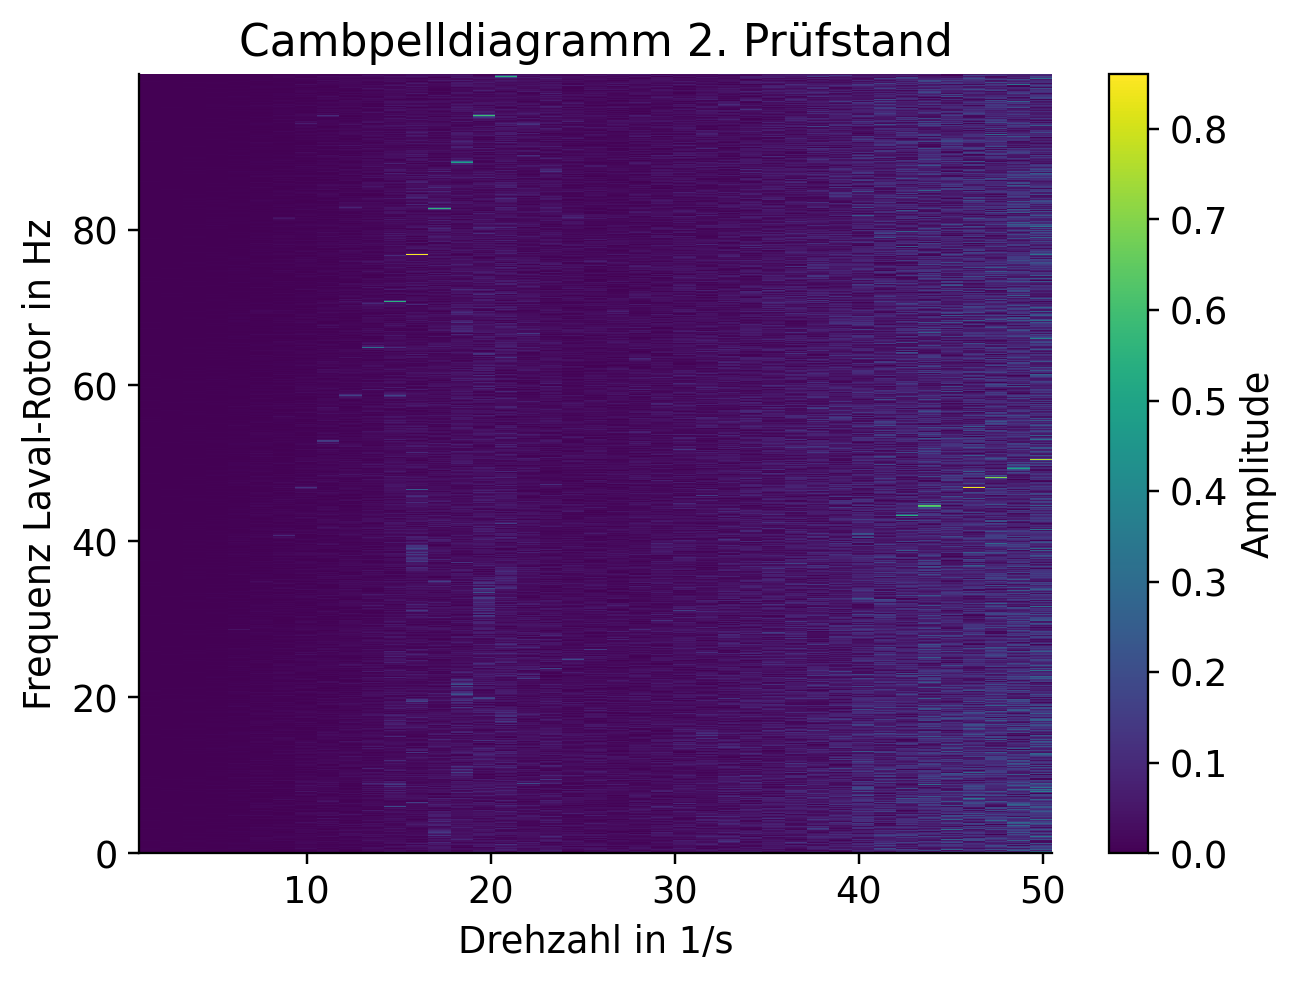

In [10]:
#aus den Messdaten die erste gemessene Drehzahl auslesen und darin den ersten array der transformation_data auslesen, was der Frequenz entspricht (transforamtion_data besteht aus den arrays der Frequenz und noch der Amplitude)
freq = measurement_data['0']["transformation_data"][1]
#leere Liste erstellen mit dem Namen rps (revolutions per second)
rps = []
#aus dem data dict die motor_rpm auslesen und rpm in rps umrechnen, indem man durch 60 teilt (Minute auf Sekunden) undder Liste dann hinzufügen
for ii in keys:
    rps.append((measurement_data[str(ii)]["motor_rpm"])/60)

#array mit dem Inhalt aus Nullen erstellen dessen Zeilenlänge die Länge von freq ist und die Spaltenlänge die Länge von rps
array_dimensions = (len(freq),len(rps))

array_campbell = np.zeros(array_dimensions)
for ii in keys:
    #arrayn füllen mit den transformierten Daten
    array_campbell[:,ii] = measurement_data[str(ii)]["transformation_data"][0]

#minimale und maximale Frequenz auslesen (erster und letzter Eintrag von freq)
minimum_freq = freq[0]
maximum_freq = freq[-1]
    
#minimale und maximale Drehzahl auslesen (erster und letzter Eintrag von rps)
minimum_rps = rps[0]
maximum_rps = rps[-1]

#mit imshow() plotten
plt.imshow(array_campbell, aspect = "auto", origin = "lower", extent = (minimum_rps, maximum_rps, minimum_freq, maximum_freq), interpolation ="none")
col = plt.colorbar()
col.set_label("Amplitude")
plt.title("Cambpelldiagramm 2. Prüfstand")
plt.ylabel("Frequenz Laval-Rotor in Hz")
plt.xlabel("Drehzahl in 1/s")

## Dritter Datensatz: Prüfstand 4

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#Daten aus der hdf5 auslesen und im dict measurement_data abspeichern
#hdf5 Pfad definieren
hdf5_path = path_measurement_folder+"/"+filename
f = h5py.File(hdf5_path,"r")

#leeres dict erstellen
measurement_data = {}
#keys erstellen um die jeweiligen Ordner der hdf5 Datei (insgesamt 20 Ordner für jeweils spezielle Drehzahlen) auszulesen zu können
keys = list(range(20))

#Schleife erstellen um Ordner nach und nach auszulesen
for ii in keys:
    #Ordner definieren (jeweils für spezielle Drehzahlen)
    foulder = str(ii)
    #Beschleunigungssensor
    acceleration_sensor = f[foulder]["RawData"][uuid_acceleration]
    #Hallsensor (also zumindest die uuid welche die Motordrehzahl misst)
    hall_sensor = f[foulder]["RawData"][uuid_motor_rpm]
    
    #Beschleunigungen und timesamps des Beschleunigungssensors auslesen
    #Die Messdaten der drei Beschleunigungsrichtungen des Sensors auslesen für die jeweiligen Drehzahlen (Ordner)
    acceleration_x = np.array(acceleration_sensor['acceleration_x'])
    acceleration_y = np.array(acceleration_sensor['acceleration_y'])
    acceleration_z = np.array(acceleration_sensor['acceleration_z'])
    #Zeit auslesen
    timestamp = np.array(acceleration_sensor['timestamp'])
    
    #Motordrehzahl auslesen gemessen vom Hallsensor
    motor_rpm = np.array(hall_sensor['motor_rpm'])
    
    #die ausgelesenen Daten in dem dict abspeichern, damit sie beim erneuten durchlaufen der for Schleife nicht überchrieben werden
    measurement_data.update({str(ii):{"acceleration_x" : acceleration_x, "acceleration_y" : acceleration_y, "acceleration_z" : acceleration_z, "timestamp" : timestamp, "motor_rpm" : motor_rpm}})


#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions
#aus dem erstellten Dict die Beschleunigungen auslesen als Input für die Funktion get_vec_accel()
#-->wieder mit einer for Schleife (es existieren Beschleunigunswerte für die jeweiligen Drehzahlbereiche)
for ii in keys:
    acc_x = measurement_data[str(ii)]["acceleration_x"]
    acc_y = measurement_data[str(ii)]["acceleration_y"]
    acc_z = measurement_data[str(ii)]["acceleration_z"]
    amount_acc_vec = m_postprocessing.get_vec_accel(acc_x, acc_y, acc_z)
    #Den Betrag des Beschleunigungsvektors dem Data dict hinzufügen
    measurement_data[str(ii)]["amount_acc_vec"] = amount_acc_vec
    
    #timestamps auslesen für die interpolation Funktion
    timestamp = measurement_data[str(ii)]["timestamp"]
    #mit den Inputs (gegebenen Interpolationspunkten und der Zeit) die jeweiligen Beträge für die jeweiligen Drehzahlen interpolieren
    interpolation_data = m_postprocessing.interpolation(timestamp, amount_acc_vec, interpolation_points)
    #Die Interpolierten Daten dem dict hinzufügen
    measurement_data[str(ii)]["interpolation_data"] = interpolation_data
    
    #Transformation der Daten in den Frequenzbereich mit der my_fft_scaled() Funktion
    transformation_data = m_postprocessing.my_fft_scaled(interpolation_data, timestamp)
    #dem dict hinzufügen
    measurement_data[str(ii)]["transformation_data"] = transformation_data    

#### 3. Darstellung mittels Campbell-Diagramm

1.5666666666666667
35.18333333333333
0.0
99.93058216458951


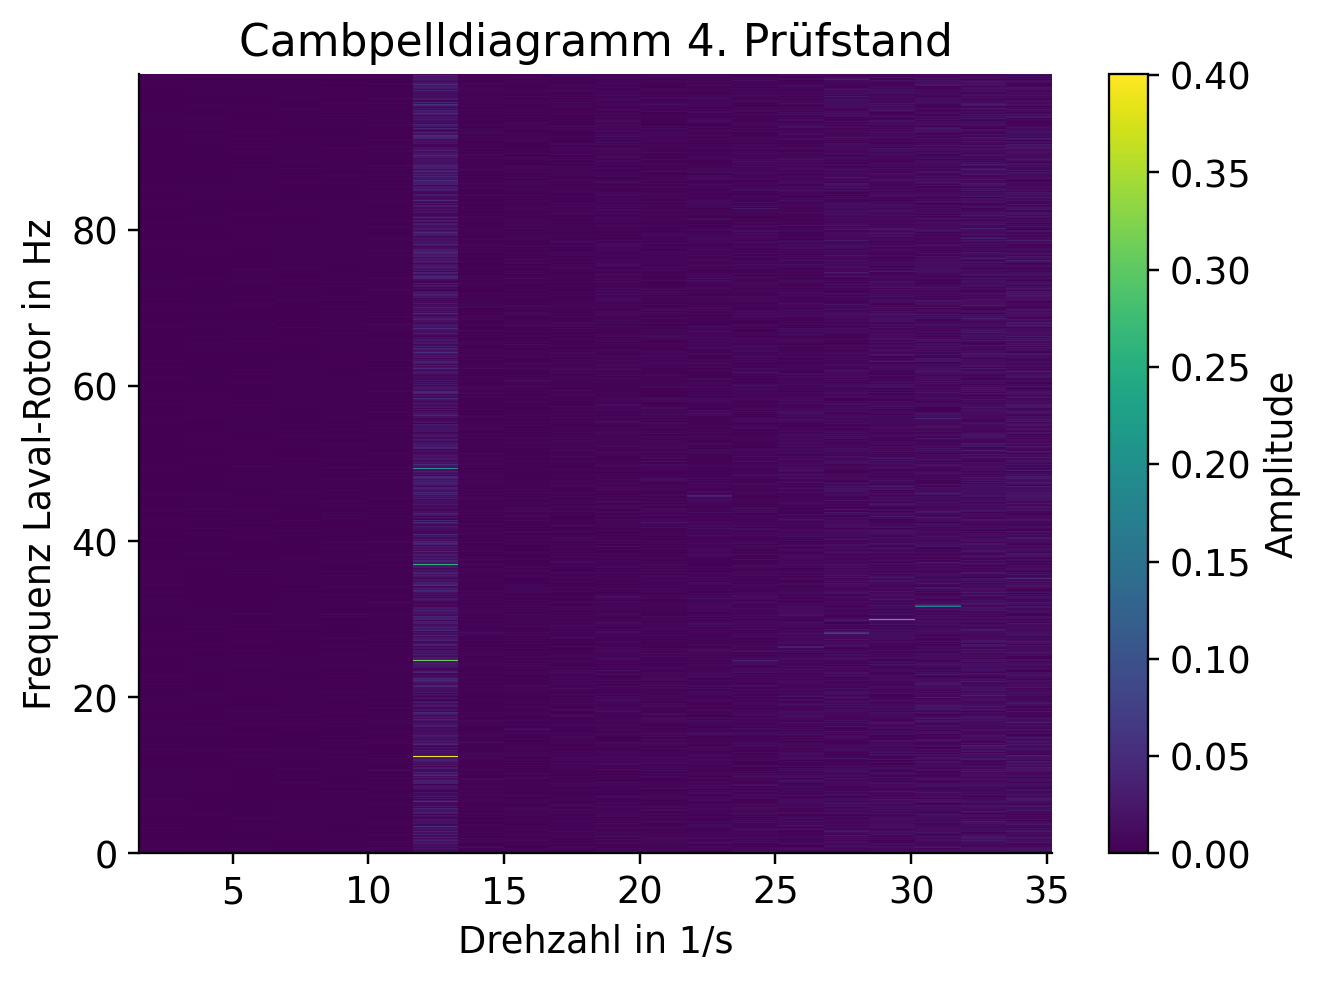

In [13]:
#aus den Messdaten die erste gemessene Drehzahl auslesen und darin den ersten array der transformation_data auslesen, was der Frequenz entspricht (transforamtion_data besteht aus den arrays der Frequenz und noch der Amplitude)
freq = measurement_data['0']["transformation_data"][1]
#leere Liste erstellen mit dem Namen rps (revolutions per second)
rps = []
#aus dem data dict die motor_rpm auslesen und rpm in rps umrechnen, indem man durch 60 teilt (Minute auf Sekunden) undder Liste dann hinzufügen
for ii in keys:
    rps.append((measurement_data[str(ii)]["motor_rpm"])/60)

#array mit dem Inhalt aus Nullen erstellen dessen Zeilenlänge die Länge von freq ist und die Spaltenlänge die Länge von rps
array_dimensions = (len(freq),len(rps))

array_campbell = np.zeros(array_dimensions)
for ii in keys:
    #arrayn füllen mit den transformierten Daten
    array_campbell[:,ii] = measurement_data[str(ii)]["transformation_data"][0]

#minimale und maximale Frequenz auslesen (erster und letzter Eintrag von freq)
minimum_freq = freq[0]
maximum_freq = freq[-1]
    
#minimale und maximale Drehzahl auslesen (erster und letzter Eintrag von rps)
minimum_rps = rps[0]
maximum_rps = rps[-1]

#mit imshow() plotten
plt.imshow(array_campbell, aspect = "auto", origin = "lower", extent = (minimum_rps, maximum_rps, minimum_freq, maximum_freq), interpolation ="none")
col = plt.colorbar()
col.set_label("Amplitude")
plt.title("Cambpelldiagramm 4. Prüfstand")
plt.ylabel("Frequenz Laval-Rotor in Hz")
plt.xlabel("Drehzahl in 1/s")
print(minimum_rps)
print(maximum_rps)
print(minimum_freq)
print(maximum_freq)

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Anhand der drei Campbell Diagramme der drei Versuche lassen sich nun kritische Drehzahlen ablesen. Diese sind erkennbar, anhand der erhöhten und steigenden Amplituden bishin zu einem Maximum (gelbe Farbe im Diagramm), welches dann die kritische Drehzahl aufzeigt. Ebenfalls sind gut die Geraden sichtbar, auf welchen sich die Amplituden stetig mit steigender Drehzahl erhöhen bishin zum Maximum. Danach sinken diese wieder. Bei nur einer Scheibe (Masse), sind dies die Winkelhalbierenden, da wir die Drehzahl in 1/s gerechnet haben und dies der Frequenz auf der y-Achse entspricht. Ist durch die unterschiedliche Schrittweite (Darstellung) auf der x und y Achse nicht direkt erkennbar. So ist im Campbell Diagramm erkennbar, dass mit steigender Drehzahl, sprich Frequenz, der Lavalrotor bei einer gewissen Drehzahl am stärksten schwingt (maximale Amplitude).

Im Campbell Diagramm von Prüfstand 3, also den ich selbst durchgeführt habe, ist die kritische Drehzahl ca. 23 1/s, also 1380 Umdrehungen pro Minute. Es ist zu erkennen, dass die Amplitude bis zu diesem Wert mit steigender Drehzahl ansteigt. Im Versuch war dies auch spürbar und hörbar, da die Vibrationen bei diesem Drehzahlniveau auffällig waren und es erst beim überschreiten dieser Drehzahl wieder ruhiger wurde.

Im Campbell Diagramm von Prüfstand 2 sind zwei Geraden erkennbar. Die kritischen Drehzahlen sind einmal 17 1/s und auch 47 1/s. Also 1020 und noch 2820 Umdrehungen pro Minute. Dies ergibt Sinn, denn bei diesem Prüfstand wurden 2 Scheiben auf der Welle montiert. Bedeutet es gibt zwei Eigenfrequenzen welche beim hochfahren der Drehzahl durchlaufen werden und zu Instabilität führen können. Grundsätzlich fällt hier im Vergleich zum 3. Prüfstands Diagramm auf, dass generell größere Bereiche kleine Amplituden besitzen und nicht null sind (hellblau eingefärbt). Das bedeutet, dass eventuell Störungen und andere Komponenten und deren Eigenfrequenzen das Ergebnis verfälscht haben könnten.

Im Campbell Diagramm von Prüfstand 4 ist rechts die Winkelhalbierende erkennbar. Aber noch eine zweite senkrechte Linie. Bei diesem Versuch wurde wie bei Prüfstand 3 aber nur eine Scheibe verwendet. Trotzdem sind Nebenmaxima zu erkennen und es gibt mehr als nur eine kritische Drehzahl. Die kritischen Drehzahlen sind hier 12 1/s und 29 1/s. Also 720 und 1740 Umdrehungen pro Minute. Grund für die Nebenmaxima kann entweder ein fehlerhafter Aufbau des Versuchs sein, also das auch etwas anderes angeregt wurde. Aber generell bräuchte man dafür mehr Infos über den Versuchsaufbau. 

Im Idealen Lavalrotor ist zu beobachten, dass der Rotor sich bei sehr hohen Drehzahlen selbst zentriert und sich dort in einem stabilen Zustand befindet. Dafür müssen die kritischen Drehzahlen (Bereich der Resonanz) aber zügig durchlauufen werden. Wenn ich es richtig verstanden habe, dann ist dies auch in den Campbell Diagrammen sichtbar. Obwohl ich mir nicht sicher bin, ob die Drehzahlen für diesen Effekt eventuell noch höher hätten sein müssen. Aber grundsätzlich, vorallem im dritten Prüfstand, sieht man sehr gut die ansteigende Amplitude bis zum Resonanz Bereich (kritisch), doch dass bei weiter steigender Drehzahlen der Rotor immer ruhiger wird (war wie gesagt auch im Labor spürbar) und die Amplitude stetig abnimmt. Auch wenn der Versuchsaufbau nicht ideal (keine Exzentrität aber trotzdem automatisch leichte Unwuchten) ist und nicht alles 100% simuliert werden kann, sollte dies zumindest ausreichend die Selbstzentrierung zeigen. 

Die Forschungsfragen sind damit auch beantwortet, da es großteils gut geklappt hat, die kritischen Drehzahlen zu ermitteln und zu visualisieren. Sicherlich ist da auch mit mehr Aufwand noch mehr Luft nach oben und man kann es noch genauer ermitteln.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Die kritische Drehzahl für den Prüfstand 3 (Ein-Scheiben-Rotor) wurde berechnet und beträgt 18,17 Hz. Also 1090,2 Umdrehungen die Minute. Verglichen mit der aus dem Campbell Diagramm, welche 23 Hz beträgt, ist dies dann doch eine recht große Abweichung. Die berechnete ist um 6 Hz geringer. Es gibt viele Gründe die dafür verantwortlich sein könnten. Die verwendete Formel zur Berechnung enthält nämlich viele Annahmen und kann die genauen Bedingungen und Dimensionierungen des Versuchs nicht genau abbilden. Dämpfung und Reibung der Lager (kommt auch auf den Lagertyp usw. an) spielen eine Rolle. Somit ist die berechnete kritische Drehzahl eine grobe Näherung, obwohl ich überrascht bin, dass die Abweichung größer ist als erwartet.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Versuch hat sehr Spaß gemacht, wie der letzte Laborversuch auch. Alles war super organisiert und hat funktioniert. Es macht mir viel Freude mit so vergleichsweise professionellen Equipment arbeiten zu können. Der Home Versuch war zwar auch interressant, vorallen weil man Dinge aus dem Alltag messen und analysieren konnte. Aber der Laborversuch mit dem Lavalrotor ist dann nochmal interessanter und es hat Spaß gemacht die Messung zu beobachten und durchzuführen. Grundsätzlich konnte ich sicherlich nochmal einiges wichtiges lernen bezüglich Messtechnik, Frequenzauswertung und besonders Eigenfrequenzen und wie wichtig es ist, diese bei einem schwingenden System zu kennen und zu beachten. Zusätzlich habe ich mit Hilfe des Campbell-Diagramms auch gelernt wie man diese visuell darstellen kann und erkennen kann. Obwohl das Campbell-Diagramm nicht einfach zu erstellen war und ich mir etwas mehr Hilfestellung gewünscht hätte, aber dazu gab es ja auch die Helpdesks. 